# Evaluating the performance of RAG Applications on Fabric: A Step-by-Step Guide

## Introduction

Evaluating the performance of the Retrieval-Augmented Generation (RAG) application is crucial to ensure it meets the user needs and delivers accurate, efficient, and reliable results. Understanding how well the application performs helps identify areas for improvement, optimize performance, and enhance user satisfaction. 

This tutorial provides a quickstart guide to using Fabric to evaluate the RAG application you built, following the steps from the previous [tutorial](https://aka.ms/Fabric/AI-blog/1RAG). The performance evaluation focuses on two main components of RAG: the retriever (based on Azure AI Search in this scenario) and the response generator (an LLM that uses the user query, retrieved context, and prompt to generate a reply for the user). The main steps in this tutorial are as follows:

1. Set up Azure OpenAI and Azure AI Search Services
2. Load the data from CMU's QA dataset of Wikipedia articles to curate a benchmark
3. Define deterministic and AI-Assisted evaluation metrics 
4. Evaluate the performance of retriever and response generator

The diagram below illustrates in a simplified form how the flow of data within a typical RAG system looks: it starts with a user asking a question, which is first passed to a component referred to as a "retriever" that helps fetch relevant context from pre-created database of knowledge. Next, the query, along with the context and instructive prompt, get passed to a "response generator" components powered by an LLM to generate an answer in conversational form, which will be presented to the user via chat bot interface. In this tutorial, we demonstrate how to "inject" two checkpoints for measuring RAG performance to get insights about the performance of each component and overall system.

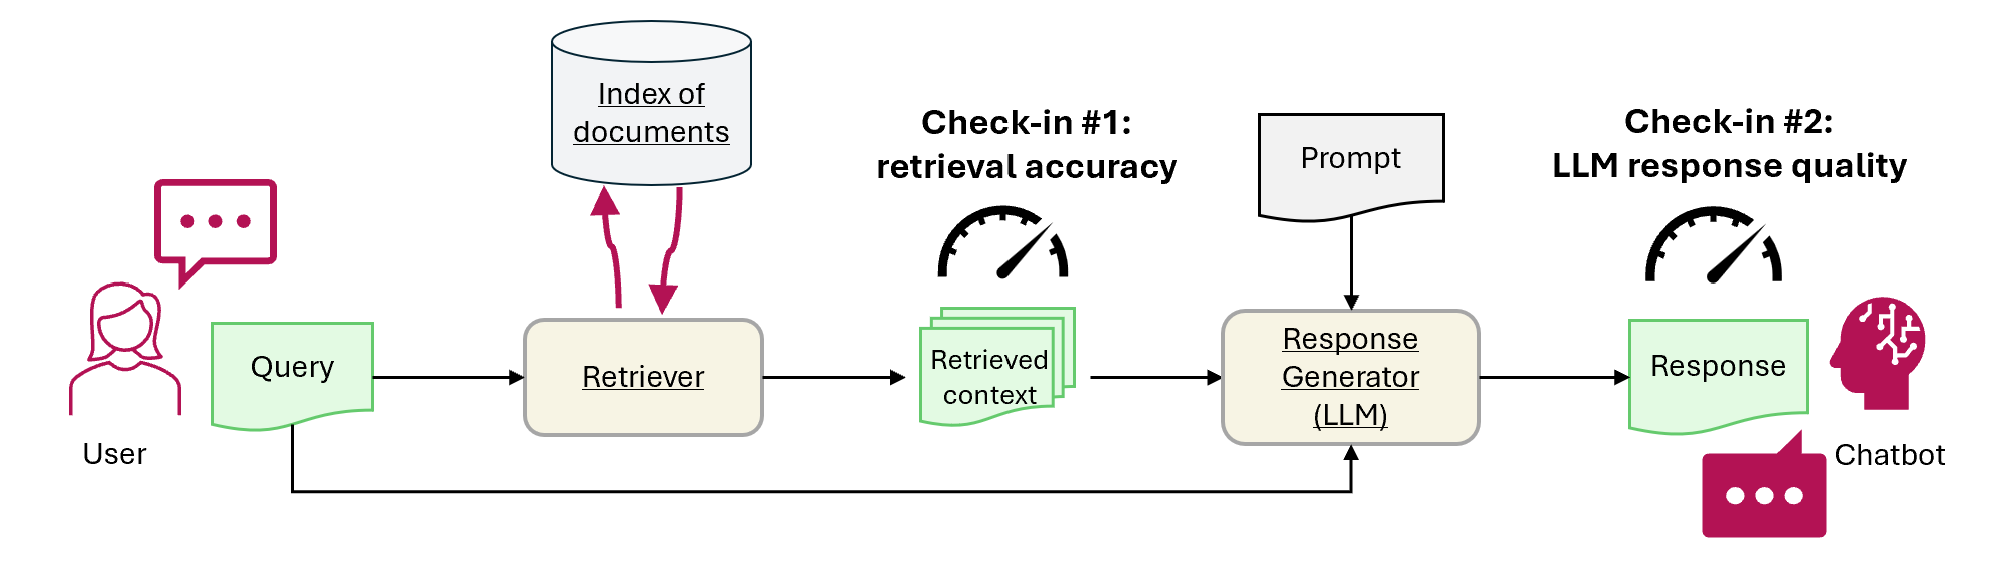

### Prerequisites

>[!NOTE]
>Before starting this tutorial, please review and run ["Building Retrieval Augmented Generation in Fabric: A Step-by-Step Guide"](https://aka.ms/fabric/quickstart-genai-guidance) tutorial.

You need the following services to run this tutorial:

- [Microsoft Fabric](https://aka.ms/fabric/getting-started)
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook
- [Azure AI Studio for OpenAI](https://aka.ms/what-is-ai-studio)
- [Azure AI Search](https://aka.ms/azure-ai-search)


## Step 1: Overview of Azure Setup

Define the endpoints and required keys to set up your Azure services. To achieve the best performance, two models are required for RAG: `text-embedding-ada-002` for embedding and the `gpt-4-32k` chat model.

In [1]:
# Fill in the following lines with your Azure OpenAI service information
aoai_endpoint = "https://.openai.azure.com" # TODO: Provide the url endpoint for your created Azure OpenAI
aoai_key = "" # TODO: Fill in your API key from Azure OpenAI 
aoai_deployment_name_embeddings = "text-embedding-ada-002"
aoai_model_name_query = "gpt-4-32k"  
aoai_model_name_metrics = "gpt-4-32k"
aoai_api_version = "2024-02-01"

# Setup key accesses to Azure AI Search
aisearch_index_name = "" # TODO: Create a new index name: must only contain lowercase, numbers, and dashes
aisearch_api_key = "" # TODO: Fill in your API key from Azure AI Search
aisearch_endpoint = "https://.search.windows.net" # TODO: Provide the url endpoint for your created Azure AI Search 

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 5, Finished, Available, Finished)

Once you have setup your Azure OpenAI and Azure AI Search Keys, you must import required libraries from [Spark](https://spark.apache.org/), [SynapseML](https://aka.ms/AboutSynapseML), [Azure Search](https://aka.ms/azure-search-libraries), and OpenAI. 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import os, requests, json, uuid

from datetime import datetime, timedelta
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient

from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp, current_timestamp, concat, col, split, explode, udf, monotonically_increasing_id, when, rand, coalesce, lit, input_file_name, regexp_extract, concat_ws, length, ceil, lit, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, ArrayType, FloatType
from pyspark.sql import Row
import pandas as pd
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import (
    VectorizedQuery,
)
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,   
    SemanticConfiguration,  
    SemanticPrioritizedFields,
    SemanticField,  
    SemanticSearch,
    VectorSearch,  
    HnswAlgorithmConfiguration,
    HnswParameters,  
    VectorSearchProfile,
    VectorSearchAlgorithmKind,
    VectorSearchAlgorithmMetric,
)

import openai  
import matplotlib.pyplot as plt 

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 6, Finished, Available, Finished)

## Step 2: Load the data into the Lakehouse and create a benchmark

### Dataset

The Carnegie Mellon University Question-Answer dataset version 1.2 is a corpus of Wikipedia articles, manually-generated factual questions based on the articles, and manually-generated answers. The data is hosted on an Azure blob storage under the same license [GFDL](http://www.gnu.org/licenses/fdl.html). For simplicity, the data is cleaned up and refined into a single structured table with the following fields.

- ArticleTitle: the name of the Wikipedia article from which questions and answers initially came.
- Question: manually generated question based on article
- Answer: manually generated answer based on question and article
- DifficultyFromQuestioner: prescribed difficulty rating for the question as given to the question-writer
- DiffuctlyFromAnswerer: Difficulty rating assigned by the individual who evaluated and answered the question, which may differ from the difficulty from DifficultyFromQuestioner
- ExtractedPath: path to original article. There may be more than one Question-Answer pair per article
- text: cleaned wikipedia artices

For more information about the license, please download a copy of the license named `LICENSE-S08,S09` from the same location.

##### History and Citation

The dataset used for this notebook requires the following citation:

    CMU Question/Answer Dataset, Release 1.2

    8/23/2013

    Noah A. Smith, Michael Heilman, and Rebecca Hw

    Question Generation as a Competitive Undergraduate Course Project

    In Proceedings of the NSF Workshop on the Question Generation Shared Task and Evaluation Challenge, Arlington, VA, September 2008. 
    Available at: http://www.cs.cmu.edu/~nasmith/papers/smith+heilman+hwa.nsf08.pdf

    Original dataset acknowledgements:
    This research project was supported by NSF IIS-0713265 (to Smith), an NSF Graduate Research Fellowship (to Heilman), NSF IIS-0712810 and IIS-0745914 (to Hwa), and Institute of Education Sciences, U.S. Department of Education R305B040063 (to Carnegie Mellon).

    cmu-qa-08-09 (modified verison)

    6/12/2024

    Amir Jafari, Alexandra Savelieva, Brice Chung, Hossein Khadivi Heris, Journey McDowell

    Released under same license GFDL (http://www.gnu.org/licenses/fdl.html)
    All the GNU license applies to the dataset in all copies.

    

### Create Benchmark

In order to validate that the RAG application works as expected, you can create a benchmark using a subset of questions prepared by CMU students found in the `S08/set1` and `S08/set2` buckets. Limit it to one question per article by applying `df.dropDuplicates(["ExtractedPath"])` to the data. Additionally, remove any duplicate questions. The complexity labels for the questions were provided during the curation process; in this example, you'll limit them to `medium`.

In [3]:
df = spark.sql("SELECT * FROM data_load_tests.cmu_qa")

# Filter the DataFrame to include only the specified paths
df = df.filter((col("ExtractedPath").like("S08/data/set1/%")) | (col("ExtractedPath").like("S08/data/set2/%")))

# Choose questions 
df = df.filter(col("DifficultyFromQuestioner") == "medium")

# Drop duplicate questions
df = df.dropDuplicates(["Question"])
df = df.dropDuplicates(["ExtractedPath"])

num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

# Persist the DataFrame
df.persist()
display(df)

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 7, Finished, Available, Finished)

Number of rows: 20, Number of columns: 7


SynapseWidget(Synapse.DataFrame, 34e516c6-771b-4978-aa58-5b76cac3d517)

As a result of this process, a dataframe with 20 rows is created, serving as the benchmark for this tutorial. Important fields include `Question`, `Answer` (the human-curated `ground truth` answer), and `ExtractedPath` (the source document where the information is found).

By adjusting the filtering criteria, you can incorporate other questions to increase diversity in complexity, creating a more realistic example. This can be a good exercise for additional experiments.

### Retriever and Response Generator

The functions defined below implement the two main components of RAG:
- the retriever (`get_context_source`)
- the response generator (`get_answer`)

You should already be familiar with the following code from the first [tutorial](https://aka.ms/fabric/quickstart-genai-guidance). Note the `topN` parameter, which lets you configure how many relevant resources to fetch from the index. In this tutorial, you will be using 3, but the optimal value may vary for different data and use cases.

In [4]:
# implementation of retriever
def get_context_source(question, topN=3):
    """
    Retrieves contextual information and sources related to a given question using embeddings and a vector search.  
    Parameters:  
    question (str): The question for which the context and sources are to be retrieved.  
    topN (int, optional): The number of top results to retrieve. Default is 3.  
      
    Returns:  
    List: A list containing two elements:  
        1. A string with the concatenated retrieved context.  
        2. A list of retrieved source paths.  
    """
    # Configure client for accessing embedding endpoint
    embed_client = openai.AzureOpenAI(
        api_version=aoai_api_version,
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
    )
    
    # Configure access to Azure AI Search
    search_client = SearchClient(
        aisearch_endpoint,
        aisearch_index_name,
        credential=AzureKeyCredential(aisearch_api_key)
    )

    query_embedding = embed_client.embeddings.create(input=question, model=aoai_deployment_name_embeddings).data[0].embedding

    vector_query = VectorizedQuery(vector=query_embedding, k_nearest_neighbors=topN, fields="Embedding")

    results = search_client.search(   
        vector_queries=[vector_query],
        top=topN,
    )

    retrieved_context = ""
    retrieved_sources = []
    for result in results:
        retrieved_context += result['ExtractedPath'] + "\n" + result['Chunk'] + "\n\n"
        retrieved_sources.append(result['ExtractedPath'])

    return [retrieved_context, retrieved_sources]

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 8, Finished, Available, Finished)

In [5]:
# Implementation of response generator
def get_answer(question, context):
    """  
    Generates a response to a given question using provided context and an Azure OpenAI model.  
    
    Parameters:  
        question (str): The question that needs to be answered.  
        context (str): The contextual information related to the question that will help generate a relevant response.  
    
    Returns:  
        str: The response generated by the Azure OpenAI model based on the provided question and context.  
    """
    messages = [
        {
            "role": "system",
            "content": "You are a chat assistant who will be provided text information for grounding your response.  Use only information provided to answer, don't make things up. Give a one-word answer whenever possible ('yes'/'no' is ok where appropriate, no details). For every word in the response that's not critical, you'll be penalized $500."
        }
    ]

    messages.append(
        {
            "role": "user", 
            "content": question + "\n" + context,
        },
    )

    chat_client = openai.AzureOpenAI(
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
        api_version=aoai_api_version,
    )

    chat_completion = chat_client.chat.completions.create(
        model=aoai_model_name_query,
        messages=messages,
    )

    return chat_completion.choices[0].message.content

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 9, Finished, Available, Finished)

### Perform an end-to-end test

Begin by performing a basic end-to-end test of the RAG system, often referred to as a `smoke test` to ensure that it actually is able to retrieve answer to your question.Start with a simple end-to-end test of the RAG, also known as "smoke test":

In [6]:
question = "How many suborders are turtles divided into?"
retrieved_context, retrieved_sources = get_context_source(question)
answer = get_answer(question, retrieved_context)
print(answer, retrieved_sources)

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 10, Finished, Available, Finished)

Three ['S08/data/set1/a9', 'S08/data/set1/a8', 'S08/data/set1/a3']


Though quick and easy to execute, this smoke test is highly informative. It helps detect potential issues in the RAG implementation, such as incorrect credentials for endpoints, missing or empty vector indexes, or incompatible function interfaces. If the test fails, pause and check for these possible issues. A successful output might look like "Three" with varying details and order of enumeration. Note that if you ask the same question again, the answer might slightly differ in wording since LLMs are not deterministic.

Now that the smoke test has passed and the RAG application appears to be working, you can proceed to evaluate its performance.

## Step 3: Define evaluation metrics

You will define metrics to quantitatively measure how well the system retrieves and generates relevant, accurate, and contextually grounded responses. By using metrics like relevance, groundedness, and similarity, you can fine-tune the system, compare different models, and track progress over time, ensuring the RAG application remains effective and reliable.

#### Deterministic metric


Begin by defining a deterministic metric to evaluate the performance of the retriever component. This metric, inspired by search engines, checks if the list of retrieved sources includes the ground truth source. Known as the `top-N` accuracy score, it measures how often the correct source appears in the top `N` results, where `N` is determined by the `topN` parameter.

In [7]:
def get_retrieval_score(target_source, retrieved_sources):
    if target_source in retrieved_sources: 
        return 1
    else: 
        return 0

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 11, Finished, Available, Finished)

According to the benchmark above, the answer is in the source with the ID `"S08/data/set1/a9"`. Testing the function `get_retrieval_score` on the example above should return 1, as expected, since the source is included in the top 3 relevant text chunks (and it is the first in the list).

In [8]:
print("Retrieved sources: ", retrieved_sources)
get_retrieval_score("S08/data/set1/a9", retrieved_sources)

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 12, Finished, Available, Finished)

Retrieved sources:  ['S08/data/set1/a9', 'S08/data/set1/a8', 'S08/data/set1/a3']


1

### AI-Assisted metric

You can also define AI-assisted metrics. You use a "few-shot" model with a prompt template (also used in Azure AI Studio) that includes examples of input (CONTEXT and ANSWER) and suggested output. For this tutorial, you focus on the following metrics that are commonly used and generally the most useful and reliable for evaluating GPT models. In this tutorial we will look at `Relevance` and `Similarity`, and you can check definitions of other metrics (`Groundedness`, `Fluency` and `Coherence`) [here](https://learn.microsoft.com/en-us/azure/ai-studio/concepts/evaluation-metrics-built-in?tabs=warning#ai-assisted-relevance).

- `Relevance`: It measures how closely the generated answer aligns with the question or prompt. It evaluates whether the response directly addresses the user's query and provides useful and pertinent information. A high relevance score indicates that the answer is closely related to the input question and is helpful.

- `Similarity`: It evaluates the degree of similarity between the model-generated answer and the human-curated reference answer. It measures how closely the wording and content of the generated response match the expected answer. A high similarity score indicates that the generated answer closely resembles the reference answer in terms of wording and content.

All metrics are rated on a scale from 1 to 5, with higher scores being better. Note that `groundedness` only requires two inputs (context and generated answer), while `relevance` and `similarity` use the `ground_truth` for evaluation.


In [9]:
def get_relevance_metric(context, question, answer):    
    relevance_prompt_template = """
    Relevance measures how well the answer addresses the main aspects of the question, based on the context. Consider whether all and only the important aspects are contained in the answer when evaluating relevance. Given the context and question, score the relevance of the answer between one to five stars using the following rating scale:
    One star: the answer completely lacks relevance
    Two stars: the answer mostly lacks relevance
    Three stars: the answer is partially relevant
    Four stars: the answer is mostly relevant
    Five stars: the answer has perfect relevance

    This rating value should always be an integer between 1 and 5. So the rating produced should be 1 or 2 or 3 or 4 or 5.

    context: Marie Curie was a Polish-born physicist and chemist who pioneered research on radioactivity and was the first woman to win a Nobel Prize.
    question: What field did Marie Curie excel in?
    answer: Marie Curie was a renowned painter who focused mainly on impressionist styles and techniques.
    stars: 1

    context: The Beatles were an English rock band formed in Liverpool in 1960, and they are widely regarded as the most influential music band in history.
    question: Where were The Beatles formed?
    answer: The band The Beatles began their journey in London, England, and they changed the history of music.
    stars: 2

    context: The recent Mars rover, Perseverance, was launched in 2020 with the main goal of searching for signs of ancient life on Mars. The rover also carries an experiment called MOXIE, which aims to generate oxygen from the Martian atmosphere.
    question: What are the main goals of Perseverance Mars rover mission?
    answer: The Perseverance Mars rover mission focuses on searching for signs of ancient life on Mars.
    stars: 3

    context: The Mediterranean diet is a commonly recommended dietary plan that emphasizes fruits, vegetables, whole grains, legumes, lean proteins, and healthy fats. Studies have shown that it offers numerous health benefits, including a reduced risk of heart disease and improved cognitive health.
    question: What are the main components of the Mediterranean diet?
    answer: The Mediterranean diet primarily consists of fruits, vegetables, whole grains, and legumes.
    stars: 4

    context: The Queen's Royal Castle is a well-known tourist attraction in the United Kingdom. It spans over 500 acres and contains extensive gardens and parks. The castle was built in the 15th century and has been home to generations of royalty.
    question: What are the main attractions of the Queen's Royal Castle?
    answer: The main attractions of the Queen's Royal Castle are its expansive 500-acre grounds, extensive gardens, parks, and the historical castle itself, which dates back to the 15th century and has housed generations of royalty.
    stars: 5

    context: {context}
    question: {question}
    answer: {answer}
    stars:
    """

    metric_client = openai.AzureOpenAI(
        api_version=aoai_api_version,
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
    )


    messages = [
        {
            "role": "system",
            "content": " You are an AI assistant. You will be given the definition of an evaluation metric for assessing the quality of an answer in a question-answering task. Your job is to compute an accurate evaluation score using the provided evaluation metric."
        }, 
        {
            "role": "user",
            "content": relevance_prompt_template.format(context=context, question=question, answer=answer)
        }
    ]

    metric_completion = metric_client.chat.completions.create(
        model=aoai_model_name_metrics,
        messages=messages,
        temperature=0,
    )

    return metric_completion.choices[0].message.content


StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 13, Finished, Available, Finished)

In [10]:
def get_similarity_metric(question, ground_truth, answer):
    similarity_prompt_template = """
    Equivalence, as a metric, measures the similarity between the predicted answer and the correct answer. If the information and content in the predicted answer is similar or equivalent to the correct answer, then the value of the Equivalence metric should be high, else it should be low. Given the question, correct answer, and predicted answer, determine the value of Equivalence metric using the following rating scale:
    One star: the predicted answer is not at all similar to the correct answer
    Two stars: the predicted answer is mostly not similar to the correct answer
    Three stars: the predicted answer is somewhat similar to the correct answer
    Four stars: the predicted answer is mostly similar to the correct answer
    Five stars: the predicted answer is completely similar to the correct answer

    This rating value should always be an integer between 1 and 5. So the rating produced should be 1 or 2 or 3 or 4 or 5.

    The examples below show the Equivalence score for a question, a correct answer, and a predicted answer.

    question: What is the role of ribosomes?
    correct answer: Ribosomes are cellular structures responsible for protein synthesis. They interpret the genetic information carried by messenger RNA (mRNA) and use it to assemble amino acids into proteins.
    predicted answer: Ribosomes participate in carbohydrate breakdown by removing nutrients from complex sugar molecules.
    stars: 1

    question: Why did the Titanic sink?
    correct answer: The Titanic sank after it struck an iceberg during its maiden voyage in 1912. The impact caused the ship's hull to breach, allowing water to flood into the vessel. The ship's design, lifeboat shortage, and lack of timely rescue efforts contributed to the tragic loss of life.
    predicted answer: The sinking of the Titanic was a result of a large iceberg collision. This caused the ship to take on water and eventually sink, leading to the death of many passengers due to a shortage of lifeboats and insufficient rescue attempts.
    stars: 2

    question: What causes seasons on Earth?
    correct answer: Seasons on Earth are caused by the tilt of the Earth's axis and its revolution around the Sun. As the Earth orbits the Sun, the tilt causes different parts of the planet to receive varying amounts of sunlight, resulting in changes in temperature and weather patterns.
    predicted answer: Seasons occur because of the Earth's rotation and its elliptical orbit around the Sun. The tilt of the Earth's axis causes regions to be subjected to different sunlight intensities, which leads to temperature fluctuations and alternating weather conditions.
    stars: 3

    question: How does photosynthesis work?
    correct answer: Photosynthesis is a process by which green plants and some other organisms convert light energy into chemical energy. This occurs as light is absorbed by chlorophyll molecules, and then carbon dioxide and water are converted into glucose and oxygen through a series of reactions.
    predicted answer: In photosynthesis, sunlight is transformed into nutrients by plants and certain microorganisms. Light is captured by chlorophyll molecules, followed by the conversion of carbon dioxide and water into sugar and oxygen through multiple reactions.
    stars: 4

    question: What are the health benefits of regular exercise?
    correct answer: Regular exercise can help maintain a healthy weight, increase muscle and bone strength, and reduce the risk of chronic diseases. It also promotes mental well-being by reducing stress and improving overall mood.
    predicted answer: Routine physical activity can contribute to maintaining ideal body weight, enhancing muscle and bone strength, and preventing chronic illnesses. In addition, it supports mental health by alleviating stress and augmenting general mood.
    stars: 5

    question: {question}
    correct answer:{ground_truth}
    predicted answer: {answer}
    stars:
    """
    
    metric_client = openai.AzureOpenAI(
        api_version=aoai_api_version,
        azure_endpoint=aoai_endpoint,
        api_key=aoai_key,
    )

    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant. You will be given the definition of an evaluation metric for assessing the quality of an answer in a question-answering task. Your job is to compute an accurate evaluation score using the provided evaluation metric."
        }, 
        {
            "role": "user",
            "content": similarity_prompt_template.format(question=question, ground_truth=ground_truth, answer=answer)
        }
    ]

    metric_completion = metric_client.chat.completions.create(
        model=aoai_model_name_metrics,
        messages=messages,
        temperature=0,
    )

    return metric_completion.choices[0].message.content

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 14, Finished, Available, Finished)

Now, you can run the following on a single question to determine the performance using different metrics which help you evaluate how well the RAG application retrieves and generates relevant, accurate, and contextually grounded responses.

In [11]:
relevance_score = get_relevance_metric(retrieved_context, question, answer) 
similarity_score = get_similarity_metric(question, 'three', answer)
# Print the outcomes
print("Relevance Score:", relevance_score)
print("Similarity Score:", similarity_score)

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 15, Finished, Available, Finished)

Relevance Score: 5
Similarity Score: 5


Highest score for similarity - 5 - means that from the perspective of GPT, the answer is completely similar to "ground truth" answer curated by human expert. Same score for relevance means that it is relevant to the question asked by the user. It is important to keep in mind that AI-assisted metrics sometimes fluctuate for the same input. However, using them is usually much quicker than involving a human judges (who are also prone to having subjective and changeable opinions)!

## Step 4: Evaluate the RAG performance on benchmark dataset

To run functions at scale and leverage Spark distributed computing, you need to create special function wrappers. Each of these wrappers should end with `_udf`, which stands for "user-defined function." In Spark, these wrappers must be decorated with `@udf(returnType=StructType([ ... ]))`, a notation that tells Spark what kind of data the function will return. This setup helps Spark understand how to handle and process the function's output and to perform calculations across large amounts of data more quickly and efficiently.

In [12]:
# UDF wrappers for RAG components
@udf(returnType=StructType([  
    StructField("retrieved_context", StringType(), True),  
    StructField("retrieved_sources", ArrayType(StringType()), True)  
]))
def get_context_source_udf(question, topN=3):
    return get_context_source(question, topN)

@udf(returnType=StringType())
def get_answer_udf(question, context):
    return get_answer(question, context)


# UDF wrapper for retrieval score metric
@udf(returnType=StringType())
def get_retrieval_score_udf(target_source, retrieved_sources):
    return get_retrieval_score(target_source, retrieved_sources)


# UDF wrappers AI-assisted metrics
@udf(returnType=StringType())
def get_groundedness_metric_udf(context, answer):
    return get_groundedness_metric(context, answer)

@udf(returnType=StringType())
def get_relevance_metric_udf(context, question, answer): 
    return get_relevance_metric(context, question, answer)

@udf(returnType=StringType())
def get_similarity_metric_udf(question, ground_truth, answer):
    return get_similarity_metric(question, ground_truth, answer)

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 16, Finished, Available, Finished)

### Retriever performance 

The code below adds two new columns `result` and `retrieval_score` to the benchmark DataFrame. The `result` column contains the answer generated by RAG, while the `retrieval_score` column indicates whether the context provided to the LLM includes the article related to the question.

In [13]:
df = df.withColumn("result", get_context_source_udf(df.Question)).select(df.columns+["result.*"])
df = df.withColumn('retrieval_score', get_retrieval_score_udf(df.ExtractedPath, df.retrieved_sources))
print("Aggregate Retrieval score: {:.2f}%".format((df.where(df["retrieval_score"] == 1).count() / df.count()) * 100))
display(df.select(["question", "retrieval_score",  "ExtractedPath", "retrieved_sources"]))

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 17, Finished, Available, Finished)

Aggregate Retrieval score: 100.00%


SynapseWidget(Synapse.DataFrame, 086b4d59-c657-4334-81d5-e9b3fda187fa)

For all questions correct context was fetched, and in most cases it is also the first entry on the list. Azure AI Search did a great job! You may wonder why in some cases context has two or three same values. It is not an error - it means that it fetched fragments of the same articles which did not fit in one chunk at splitting stage.

### Response generator performance

Once you have verified the performance of the retreiver, you can check the performance of the response generator. Send the questions and the context to the LLM to generate answers. Store these answers in the `generated_answer` column of the DataFrame.

In [14]:
df = df.withColumn('generated_answer', get_answer_udf(df.Question, df.retrieved_context))

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 18, Finished, Available, Finished)

Use the generated answer, ground truth answer, question, and the context to measure all of the discussed metrics and display the evaluation results for each question-answer pair.

In [15]:
df = df.withColumn('gpt_relevance', get_relevance_metric_udf(df.retrieved_context, df.Question, df.generated_answer))
df = df.withColumn('gpt_similarity', get_similarity_metric_udf(df.Question, df.Answer, df.generated_answer))
display(df.select(["question", "answer", "generated_answer", "retrieval_score", "gpt_relevance", "gpt_similarity"]))

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 19, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 85dd85cb-6f35-41cd-88bc-c7a4d03e0dd3)

What do these values tell us? To make them easier to interpret, plot a histogram of values of Relevance and Similarity.  The LLM is more verbose than humans who were preparing the "ground truth" answers, which impacted Similarity metric (about half answers are semantically correct, but got only 4 stars as "mostly" similar).The majority of values for all three metrics are 4 o 5, which suggests that RAG performance is good.  There are a few outliers - e.g. to question `How many species of otter are there?` the model generated answer `There are 13 species of otter`, which is correct answer with high relevance and similarity at level 5, but for some reason GPT considered it to be poorly grounded on the provided context and gave it only 1 star. In other three cases when there is at least one AI-assisted metric of 1 star, it aptly points to a question with bad answer. We can see that like humans, the LLM is occasionally wrong with evaluation - but in the majority of cases it did a good job!

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 20, Finished, Available, Finished)

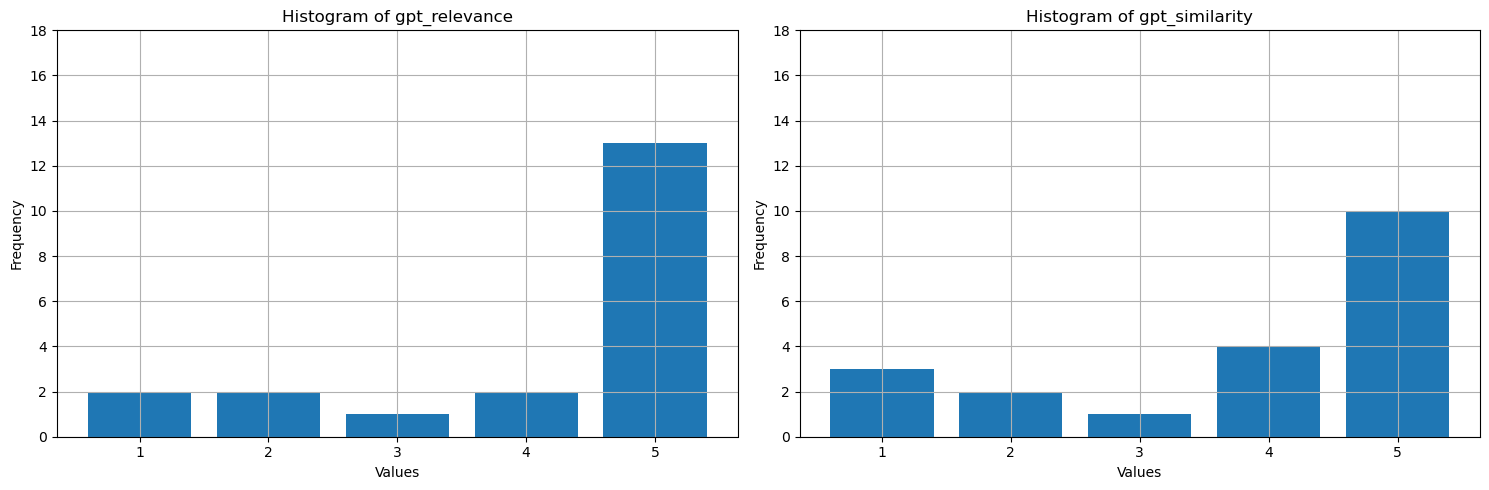

In [16]:
# Convert Spark DataFrame to Pandas DataFrame
selected_columns = ['gpt_relevance', 'gpt_similarity']
pandas_df = df.toPandas()
trimmed_df = pandas_df[selected_columns].astype(int)

# Define a function to plot histograms for the specified columns
def plot_histograms(dataframe, columns):
    # Set up the figure size and subplots
    plt.figure(figsize=(15, 5))
    for i, column in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        # Filter the dataframe to only include rows with values 1, 2, 3, 4, 5
        filtered_df = dataframe[dataframe[column].isin([1, 2, 3, 4, 5])]
        filtered_df[column].hist(bins=range(1, 7), align='left', rwidth=0.8)
        plt.title(f'Histogram of {column}')
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.xticks(range(1, 6))
        plt.yticks(range(0, 20, 2))


# Call the function to plot histograms for the specified columns
plot_histograms(trimmed_df, selected_columns)

# Show the plots
plt.tight_layout()
plt.show()

### Save to the lakehouse

You can save the results of the benchmark run to a table in your lakehouse. While this is optional, it is highly recommended. This step is valuable because it allows you to track changes made to the RAG system, such as modifications to the prompt, updates to the index, or using a different GPT version. By saving these results, you can measure performance improvements or identify any regressions.

In [18]:
# create name of experiment that is easy to refer to
friendly_name_of_experiment = "rag_tutorial_experiment_1"

# Note the current date and time  
time_of_experiment = current_timestamp()

# Generate a unique GUID for all rows
experiment_id = str(uuid.uuid4())

# Add two new columns to the Spark DataFrame
updated_df = df.withColumn("execution_time", time_of_experiment) \
                        .withColumn("experiment_id", lit(experiment_id)) \
                        .withColumn("experiment_friendly_name", lit(friendly_name_of_experiment))

# Store the updated DataFrame in the default lakehouse as a table named 'rag_experiment_runs'
table_name = "rag_experiment_runs" 
updated_df.write.format("parquet").mode("append").saveAsTable(table_name)

StatementMeta(, 2a2f092f-7c12-4a32-b2be-9ee5db7f59e9, 22, Finished, Available, Finished)

With that, you can return to results of your experiment at any point to review it, compare with new experiments, decide on which configuration will work best for your production release, etc.! 

By getting to this step, you should be comfortable with using AI-assisted metrics and topN retrieval rate for building your RAG.

In the upcoming tutorials, you'll continue the journey to GenAI with Fabric - next steps will be showing how to modify configuration of your RAG to suit the scenario in the best way. 